In [1]:
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) *
                error ** k *
                (1-error)**(n_classifier - k)
                for k in range(k_start, n_classifier+1)]
    return sum(probs)

ensemble_error(n_classifier=11, error=0.25)


0.03432750701904297

In [2]:
import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0, 1.01, 0.01)
ens_erros = [ensemble_error(n_classifier=11, error=error)
                for error in error_range]

plt.plot(error_range, ens_erros,
            label="Ensemble error", linewidth=2)
plt.plot(error_range, error_range,
            linestyle='--', label="Base error", linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()


<Figure size 640x480 with 1 Axes>

In [3]:
np.argmax(np.bincount([0, 0, 1],
                        weights=[0.2, 0.2, 0.6]))


1

In [4]:
ex = np.array([[0.9, 0.1],
                [0.8, 0.2],
                [0.4, 0.6]])

p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p



array([0.58, 0.42])

In [5]:
np.argmax(p)


0

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """ 多数決アンサンブル分類器

    params
    ----------------
    classifiers: array-like, shape = [n_classifier]
        - 様々な分類器
    
    vote : str, {'classlabel', 'probability'} (default: 'classlabel')
        - classlabelの場合、クラスラベルの予測はクラスラベルのargmaxに基づく
        - probabilityの場合、クラスラベルの予測はクラスの所属確率argmaxに基づく。
            (分類器が調整済みであることが推奨)

    weights: array-like, shape = [n_classifiers] (optional, default = None)
        - int, floatの型の値のリストが提供された場合、分類器は重要度で重み付けされる。
        - Noneの場合は均一な重みとなる
    
    """

    def __init__(self, classifiers, vote='classlabel', weights=None):
        
        self.classifiers = classifiers
        self.name_classifiers = {key: value for key, value 
                                    in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
    
    def fit(self, X, y):
        """ 分類機を学習させる """

        # クラスラベルが0から始まるように
        # self.predictのargmax呼び出しで重要となる
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)

        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []

        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        
        return self

    def predict(self, X):
        """ Xのクラスラベルを予測する """

        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            # clf.predict 呼び出しの結果を収集
            predictions = np.asarray([clf.predict(X)
                                        for clf in self.classifiers_]).T
            
            # 各サンプルのクラス確率に重みを書けて足し合わせた値が最大となる
            # 列番号を配列として返す
            maj_vote = np.apply_along_axis(
                lambda x:
                np.argmax(np.bincount(x, weights=self.weights)),
                axis=1,
                arr=predictions
            )
        
        # 各サンプルに確率の最大値を与えるクラスラベルを抽出
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        """ Xのクラス確率を予測する """

        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])

        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        """ GridSearchの実行時に分類金パラメータ名を取得 """
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            # キューを"分類器の名前__パラメータ名",
            # バリューをパラメータの値とするディクショナリを生成
            out = self.name_classifiers.copy()
            for name, step in six.iteritems(self.name_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out


/Users/yuuki/miniconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [7]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]

le = LabelEncoder()
y = le.fit_transform(y)


In [8]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, random_state=1, stratify=y) 


In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2',
                            C=0.001,
                            random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                            criterion='entropy',
                            random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                    ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                    ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                                X=X_train,
                                y=y_train,
                                cv=10,
                                scoring='roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))


10-fold cross validation:

ROC AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]


In [10]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                                X=X_train,
                                y=y_train,
                                cv=10,
                                scoring='roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))



ROC AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]
ROC AUC: 0.94 (+/- 0.13) [Majority voting]


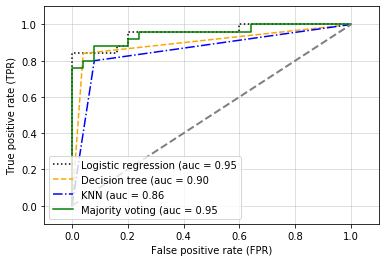

In [11]:
from sklearn.metrics import roc_curve, auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # 陽性のクラスラベルは1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, threshold = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
                color=clr,
                linestyle=ls,
                label='%s (auc = %0.2f' % (label, roc_auc))

plt.legend(loc='lower left')
plt.plot([0, 1], [0, 1],
        linestyle='--',
        color='gray',
        linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()


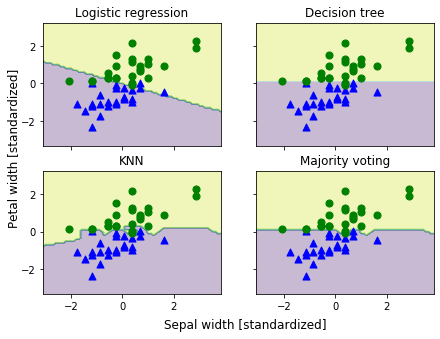

In [12]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

from itertools import product

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                        np.arange(y_min, y_max, 0.1))

# 描画領域を2x2に分割
f, axarr = plt.subplots(nrows=2, ncols=2,
                        sharex='col', 
                        sharey='row',
                        figsize=(7, 5))

# 決定領域のプロット
# idxは各分類機を描画すると行と列の位置を表すタプル
for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                X_train_std[y_train==0, 1],
                                c='blue',
                                marker='^',
                                s=50)

    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                X_train_std[y_train==1, 1],
                                c='green',
                                marker='o',
                                s=50)

    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5.,
            s='Sepal width [standardized]',
            ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5,
            s='Petal width [standardized]',
            ha='center', va='center', fontsize=12, rotation=90)
plt.show()



In [13]:
mv_clf.get_params()


{'pipeline-1': Pipeline(memory=None,
          steps=[('sc',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ['clf',
                  LogisticRegression(C=0.001, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='warn', n_jobs=None,
                                     penalty='l2', random_state=1, solver='warn',
                                     tol=0.0001, verbose=0, warm_start=False)]],
          verbose=False),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=

In [14]:
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2],
            'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')

grid.fit(X_train, y_train)


/Users/yuuki/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
                                                                    steps=[('sc',
                                                                            StandardScaler(copy=True,
                                                                                           with_mean=True,
                                                                                           with_std=True)),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               class_weight=None,
                                                                                               dual=False,
                                                           

In [15]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
        % (grid.cv_results_['mean_test_score'][r], 
            grid.cv_results_['std_test_score'][r] / 2.0, 
            grid.cv_results_['params'][r]))


0.933 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.04 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.04 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [16]:
print('Best param: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)


Best param: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
Accuracy: 0.97


In [17]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                        'machine-learning-databases/wine/wine.data',
                        header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                    'Alcalinity of ash', 'Magnesium', 'Total phenols',
                    'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                    'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                    'Proline']

# クラス1を削除
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values


In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                        test_size=0.2,
                                        random_state=1,
                                        stratify=y)


In [19]:
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy',
                                max_depth=None, random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                            n_estimators=500,
                            max_samples=1.0,
                            max_features=1.0,
                            bootstrap=True,
                            bootstrap_features=False,
                            n_jobs=1,
                            random_state=1)


In [20]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))


Decision tree train/test accuracies 1.000/0.833


In [21]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)

print('Bagging tree train/test accuracies %.3f/%.3f' % (bag_train, bag_test))


Bagging tree train/test accuracies 1.000/0.917


In [26]:
x_min = X_train[:, 0].min() - 1
X_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                        np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2,
                        sharex='col', 
                        sharey='row',
                        figsize=(8, 3))

# 決定領域のプロット
# idxは各分類機を描画すると行と列の位置を表すタプル
for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train_std[y_train==0, 0],
                                X_train_std[y_train==0, 1],
                                c='blue',
                                marker='^')

    axarr[idx].scatter(X_train_std[y_train==0, 0],
                                X_train_std[y_train==0, 1],
                                c='blue',
                                marker='^')

    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5.,
            s='Sepal width [standardized]',
            ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5,
            s='Petal width [standardized]',
            ha='center', va='center', fontsize=12, rotation=90)
plt.show()


ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

In [27]:
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) *
                error ** k *
                (1-error)**(n_classifier - k)
                for k in range(k_start, n_classifier+1)]
    return sum(probs)

ensemble_error(n_classifier=11, error=0.25)


0.03432750701904297

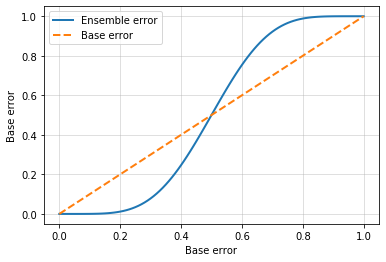

In [28]:
import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0, 1.01, 0.01)
ens_erros = [ensemble_error(n_classifier=11, error=error)
                for error in error_range]

plt.plot(error_range, ens_erros,
            label="Ensemble error", linewidth=2)
plt.plot(error_range, error_range,
            linestyle='--', label="Base error", linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()


In [29]:
np.argmax(np.bincount([0, 0, 1],
                        weights=[0.2, 0.2, 0.6]))


1

In [30]:
ex = np.array([[0.9, 0.1],
                [0.8, 0.2],
                [0.4, 0.6]])

p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p



array([0.58, 0.42])

In [31]:
np.argmax(p)


0

In [32]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """ 多数決アンサンブル分類器

    params
    ----------------
    classifiers: array-like, shape = [n_classifier]
        - 様々な分類器
    
    vote : str, {'classlabel', 'probability'} (default: 'classlabel')
        - classlabelの場合、クラスラベルの予測はクラスラベルのargmaxに基づく
        - probabilityの場合、クラスラベルの予測はクラスの所属確率argmaxに基づく。
            (分類器が調整済みであることが推奨)

    weights: array-like, shape = [n_classifiers] (optional, default = None)
        - int, floatの型の値のリストが提供された場合、分類器は重要度で重み付けされる。
        - Noneの場合は均一な重みとなる
    
    """

    def __init__(self, classifiers, vote='classlabel', weights=None):
        
        self.classifiers = classifiers
        self.name_classifiers = {key: value for key, value 
                                    in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
    
    def fit(self, X, y):
        """ 分類機を学習させる """

        # クラスラベルが0から始まるように
        # self.predictのargmax呼び出しで重要となる
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)

        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []

        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        
        return self

    def predict(self, X):
        """ Xのクラスラベルを予測する """

        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            # clf.predict 呼び出しの結果を収集
            predictions = np.asarray([clf.predict(X)
                                        for clf in self.classifiers_]).T
            
            # 各サンプルのクラス確率に重みを書けて足し合わせた値が最大となる
            # 列番号を配列として返す
            maj_vote = np.apply_along_axis(
                lambda x:
                np.argmax(np.bincount(x, weights=self.weights)),
                axis=1,
                arr=predictions
            )
        
        # 各サンプルに確率の最大値を与えるクラスラベルを抽出
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        """ Xのクラス確率を予測する """

        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])

        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        """ GridSearchの実行時に分類金パラメータ名を取得 """
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            # キューを"分類器の名前__パラメータ名",
            # バリューをパラメータの値とするディクショナリを生成
            out = self.name_classifiers.copy()
            for name, step in six.iteritems(self.name_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out


In [33]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]

le = LabelEncoder()
y = le.fit_transform(y)


In [34]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, random_state=1, stratify=y) 


In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2',
                            C=0.001,
                            random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                            criterion='entropy',
                            random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                    ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                    ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                                X=X_train,
                                y=y_train,
                                cv=10,
                                scoring='roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))


10-fold cross validation:

ROC AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]


In [36]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                                X=X_train,
                                y=y_train,
                                cv=10,
                                scoring='roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))



ROC AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]
ROC AUC: 0.94 (+/- 0.13) [Majority voting]


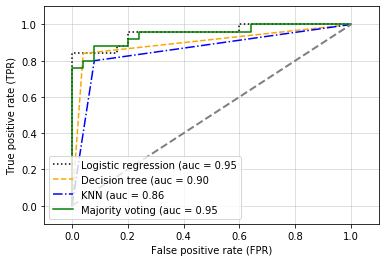

In [37]:
from sklearn.metrics import roc_curve, auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # 陽性のクラスラベルは1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, threshold = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
                color=clr,
                linestyle=ls,
                label='%s (auc = %0.2f' % (label, roc_auc))

plt.legend(loc='lower left')
plt.plot([0, 1], [0, 1],
        linestyle='--',
        color='gray',
        linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()


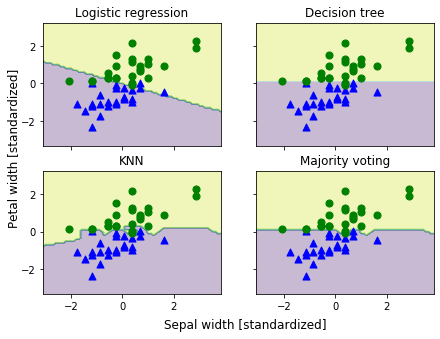

In [38]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

from itertools import product

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                        np.arange(y_min, y_max, 0.1))

# 描画領域を2x2に分割
f, axarr = plt.subplots(nrows=2, ncols=2,
                        sharex='col', 
                        sharey='row',
                        figsize=(7, 5))

# 決定領域のプロット
# idxは各分類機を描画すると行と列の位置を表すタプル
for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                X_train_std[y_train==0, 1],
                                c='blue',
                                marker='^',
                                s=50)

    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                X_train_std[y_train==1, 1],
                                c='green',
                                marker='o',
                                s=50)

    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5.,
            s='Sepal width [standardized]',
            ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5,
            s='Petal width [standardized]',
            ha='center', va='center', fontsize=12, rotation=90)
plt.show()



In [39]:
mv_clf.get_params()


{'pipeline-1': Pipeline(memory=None,
          steps=[('sc',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ['clf',
                  LogisticRegression(C=0.001, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='warn', n_jobs=None,
                                     penalty='l2', random_state=1, solver='warn',
                                     tol=0.0001, verbose=0, warm_start=False)]],
          verbose=False),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=

In [40]:
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2],
            'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')

grid.fit(X_train, y_train)


/Users/yuuki/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
                                                                    steps=[('sc',
                                                                            StandardScaler(copy=True,
                                                                                           with_mean=True,
                                                                                           with_std=True)),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               class_weight=None,
                                                                                               dual=False,
                                                           

In [41]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
        % (grid.cv_results_['mean_test_score'][r], 
            grid.cv_results_['std_test_score'][r] / 2.0, 
            grid.cv_results_['params'][r]))


0.933 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.04 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.04 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [42]:
print('Best param: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)


Best param: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
Accuracy: 0.97


In [43]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                        'machine-learning-databases/wine/wine.data',
                        header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                    'Alcalinity of ash', 'Magnesium', 'Total phenols',
                    'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                    'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                    'Proline']

# クラス1を削除
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values


In [44]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                        test_size=0.2,
                                        random_state=1,
                                        stratify=y)


In [45]:
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy',
                                max_depth=None, random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                            n_estimators=500,
                            max_samples=1.0,
                            max_features=1.0,
                            bootstrap=True,
                            bootstrap_features=False,
                            n_jobs=1,
                            random_state=1)


In [46]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))


Decision tree train/test accuracies 1.000/0.833


In [47]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)

print('Bagging tree train/test accuracies %.3f/%.3f' % (bag_train, bag_test))


Bagging tree train/test accuracies 1.000/0.917


In [48]:
x_min = X_train[:, 0].min() - 1
X_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                        np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2,
                        sharex='col', 
                        sharey='row',
                        figsize=(8, 3))

# 決定領域のプロット
# idxは各分類機を描画すると行と列の位置を表すタプル
for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train_std[y_train==0, 0],
                                X_train_std[y_train==0, 1],
                                c='blue',
                                marker='^')

    axarr[idx].scatter(X_train_std[y_train==0, 0],
                                X_train_std[y_train==0, 1],
                                c='blue',
                                marker='^')

    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5.,
            s='Sepal width [standardized]',
            ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5,
            s='Petal width [standardized]',
            ha='center', va='center', fontsize=12, rotation=90)
plt.show()


ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

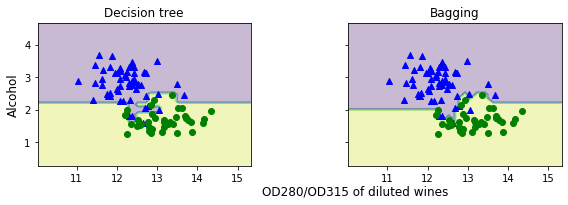

In [51]:
x_min = X_train[:, 0].min() - 1
X_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                        np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2,
                        sharex='col', 
                        sharey='row',
                        figsize=(8, 3))

# 決定領域のプロット
# idxは各分類機を描画すると行と列の位置を表すタプル
for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],
                        X_train[y_train==0, 1],
                        c='blue',
                        marker='^')

    axarr[idx].scatter(X_train[y_train==1, 0],
                        X_train[y_train==1, 1],
                        c='green',
                        marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -0.5,
        s='OD280/OD315 of diluted wines',
        ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

In [56]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                                max_depth=1,
                                random_state=1)

ada = AdaBoostClassifier(base_estimator=tree,
                        n_estimators=500,
                        learning_rate=0.1,
                        random_state=1)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
        % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies %.3f/%.3f'
        % (ada_train, ada_test))

Decision tree train/test accuracies 0.916/0.875
AdaBoost train/test accuracies 1.000/0.917


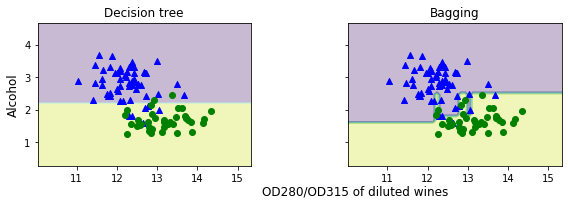

In [57]:
x_min = X_train[:, 0].min() - 1
X_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                        np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2,
                        sharex='col', 
                        sharey='row',
                        figsize=(8, 3))

for idx, clf, tt in zip([0, 1], [tree, ada], ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],
                        X_train[y_train==0, 1],
                        c='blue',
                        marker='^')

    axarr[idx].scatter(X_train[y_train==1, 0],
                        X_train[y_train==1, 1],
                        c='green',
                        marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -0.5,
        s='OD280/OD315 of diluted wines',
        ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()